## Acknowledgement   
This project use data from https://www.kaggle.com/paultimothymooney/blood-cells. These cell images are augmented from https://github.com/Shenggan/BCCD_Dataset, which contains 410 white blood cell images with annotation. The augmented dataset increases the number of samples as well as balance the ratio of images from different cell types. The final data set contains about 12500 images for training and test use. 

In [41]:
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Lambda, MaxPool2D, BatchNormalization,Input
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from keras.applications import InceptionResNetV2
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from imgaug import augmenters as iaa
from keras.optimizers import Adam
from keras.models import load_model
import sklearn
import itertools
import cv2
import scipy
import os
import csv
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Initialization

Project the type of blood cells to numerical labels:  
**1: Neutrophil  
2: Eosinophil  
3: Monocyte  
4: Lymphocyte**

In [33]:
dict_characters = {'NEUTROPHIL':0,'EOSINOPHIL':1,'MONOCYTE':2,'LYMPHOCYTE':3}
dict_characters2 = {0:'NEUTROPHIL',1:'EOSINOPHIL',2:'MONOCYTE',3:'LYMPHOCYTE'}

We can plot some images from different cell types.

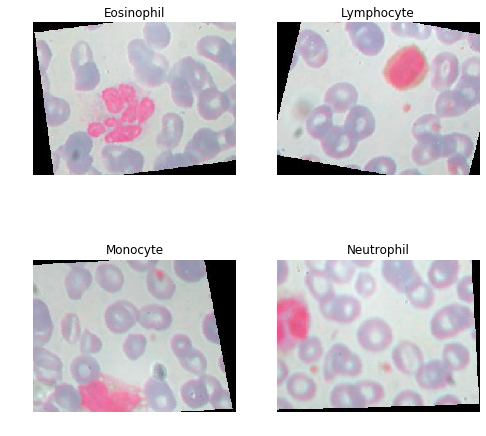

In [34]:
plt.figure(figsize=(8,8))

image_name = './bcc/TRAIN/EOSINOPHIL/_0_207.jpeg'
plt.subplot(221)
plt.title('Eosinophil')
plt.axis('off') 
plt.imshow(cv2.imread(image_name))

image_name = './bcc/TRAIN/LYMPHOCYTE/_0_204.jpeg'
plt.subplot(222)
plt.title('Lymphocyte')
plt.axis('off') 
plt.imshow(cv2.imread(image_name))

image_name = './bcc/TRAIN/MONOCYTE/_0_180.jpeg'
plt.subplot(223)
plt.title('Monocyte')
plt.axis('off') 
plt.imshow(cv2.imread(image_name))

image_name = './bcc/TRAIN/NEUTROPHIL/_0_292.jpeg'
plt.subplot(224)
plt.title('Neutrophil')
plt.axis('off') 
plt.imshow(cv2.imread(image_name))

In these images, the blackground blurred cells are red blood cells, while the highlight cells are white cells that we desire to categorize. By comparison, we can see that there are indeed shape and pattern difference among these white cells. For example, eosinophil in shape is a cell cluster while lymphocyte looks like a single large cell. Therefore, it is possible that the neural network will classify these cell images according to their respective features.

## Preprocess

These are some hyperparameters we may adjust according to the model performance

In [37]:
BATCH_SIZE = 20              # Batch size
NUM_CLASS = 4                # Number of class
EPOCHES = 100                # Training epoches
ROWS,COLS = 240,320          # Image size
INPUT_SHAPE = (ROWS,COLS,3)  # Shape of image
VAL_RATIO = 0.2              # Train test split ratio
DIR = './data/'              # Data directory

In [38]:
# Data Set
train_path = DIR + 'train/'
test_path = DIR + 'test/'

train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

X_train = []
Y_train = np.array(train_data['label'])
for name in train_data['id']:
    X_train.append(os.path.join(train_path, name))
X_train = np.array(X_train)
X_train,X_val,Y_train,Y_val = train_test_split(X_train,Y_train,test_size=VAL_RATIO, random_state=0)

X_test = []
Y_test = np.array(test_data['label'])
for name in test_data['id']:
    X_test.append(os.path.join(test_path, name))
X_test = np.array(X_test)

{0: 'NEUTROPHIL', 1: 'EOSINOPHIL', 2: 'MONOCYTE', 3: 'LYMPHOCYTE'}


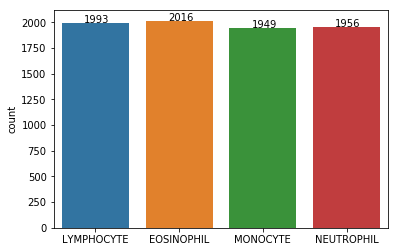

In [39]:
lab = [dict_characters2[i] for i in Y_train]
ax = sns.countplot(lab)
print(dict_characters2)

for p in ax.patches:
    ax.annotate(p.get_height(), (p.get_x()+p.get_width()/3, p.get_height()))

In [40]:
data_size = pd.DataFrame([[len(X_train),len(X_val),len(X_test)]],columns = ['train','validation','test'])
data_size

,train,validation,test
0,7914,1979,2476


The distribution of samples from each class as well as that of train, validation and test dataset.

## Training

The model structure is shown below.

In [50]:
# Model structure
model = Sequential()

model.add(InceptionResNetV2(include_top=False, weights='imagenet',input_shape=INPUT_SHAPE))
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(NUM_CLASS, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=Adam(1e-3),
              metrics=['accuracy'])

model.layers[0].trainable = True

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Model)  (None, 6, 8, 1536)        54336736  
_________________________________________________________________
conv2d_865 (Conv2D)          (None, 4, 6, 32)          442400    
_________________________________________________________________
batch_normalization_867 (Bat (None, 4, 6, 32)          128       
_________________________________________________________________
conv2d_866 (Conv2D)          (None, 2, 4, 64)          18496     
_________________________________________________________________
batch_normalization_868 (Bat (None, 2, 4, 64)          256       
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 1, 2, 64)          0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 1, 2, 64)          0         
__________

In [19]:
# Data Generator
class data_generator:
    def create_train(X,Y,batch_size,input_shape,augument=True):
        assert len(X) == len(Y)
        while True:
            random_indexes = np.random.choice(len(X), batch_size)
            batch_images = np.empty((batch_size, ROWS, COLS, 3))
            batch_labels = np.zeros((batch_size, NUM_CLASS))
            for i, idx in enumerate(random_indexes):
                image = data_generator.load_img(X[idx],input_shape)
                if augument:
                    image = data_generator.augment(image)
                batch_images[i] = image
                batch_labels[i][Y[idx]] = 1
            yield batch_images, batch_labels
    
    
    def load_img(path,shape):
        image = cv2.imread(path)
        image = cv2.resize(image,(shape[1],shape[0]))
        image = cv2.normalize(image,image,0,255,cv2.NORM_MINMAX)
        image = np.divide(image,255)
        
        return image
        
    
    # randomly process images to create more samples        
    def augment(image):                  
        augment_img = iaa.Sequential([
            iaa.OneOf([
                iaa.Affine(rotate=0),
                iaa.Affine(rotate=90),
                iaa.Affine(rotate=180),
                iaa.Affine(rotate=270),
                iaa.Fliplr(0.5),
                iaa.Flipud(0.5),
            ])], random_order=True)
        
        image_aug = augment_img.augment_image(image)
        return image_aug

In [20]:
checkPointer = ModelCheckpoint('./model/BCC.model',monitor='val_loss',save_best_only=True)
reduceLROnPlato = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, mode='min')
earlyStopping = EarlyStopping(monitor='val_loss',min_delta=1e-3,patience=10)

In [21]:
train_generator = data_generator.create_train(X_train,Y_train,BATCH_SIZE,INPUT_SHAPE,augument=True)
validation_generator = data_generator.create_train(X_val,Y_val,256,INPUT_SHAPE,augument=False)

In [22]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=50, 
                              validation_data=next(validation_generator),
                              epochs=EPOCHES,
                              callbacks=[checkPointer,reduceLROnPlato,earlyStopping])

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
50/50 [==============================] - ETA: 35:18 - loss: 3.1056 - acc: 0.15 - ETA: 17:37 - loss: 2.8860 - acc: 0.17 - ETA: 11:42 - loss: 2.4991 - acc: 0.23 - ETA: 8:45 - loss: 2.3842 - acc: 0.2250 - ETA: 6:58 - loss: 2.3076 - acc: 0.260 - ETA: 5:46 - loss: 2.2762 - acc: 0.283 - ETA: 4:55 - loss: 2.3079 - acc: 0.292 - ETA: 4:16 - loss: 2.2670 - acc: 0.300 - ETA: 3:46 - loss: 2.2896 - acc: 0.305 - ETA: 3:21 - loss: 2.3163 - acc: 0.300 - ETA: 3:01 - loss: 2.3426 - acc: 0.300 - ETA: 2:44 - loss: 2.3383 - acc: 0.291 - ETA: 2:30 - loss: 2.3721 - acc: 0.276 - ETA: 2:17 - loss: 2.3419 - acc: 0.267 - ETA: 2:07 - loss: 2.2846 - acc: 0.290 - ETA: 1:57 - loss: 2.2539 - acc: 0.296 - ETA: 1:48 - loss: 2.2634 - acc: 0.285 - ETA: 1:41 - loss: 2.2574 - acc: 0.288 - ETA: 1:34 - loss: 2.2577 - acc: 0.286 - ETA: 1:27 - loss: 2.2715 - acc: 0.287 - ETA: 1:21 - loss: 2.2799 - acc: 0.292 - ETA: 1:16 - loss: 2.2897 - acc: 0.290 - ETA: 1:11 - loss: 

50/50 [==============================] - ETA: 40s - loss: 0.6077 - acc: 0.85 - ETA: 40s - loss: 0.5892 - acc: 0.80 - ETA: 39s - loss: 0.5608 - acc: 0.78 - ETA: 38s - loss: 0.5403 - acc: 0.78 - ETA: 37s - loss: 0.5148 - acc: 0.80 - ETA: 37s - loss: 0.4842 - acc: 0.81 - ETA: 36s - loss: 0.5001 - acc: 0.80 - ETA: 35s - loss: 0.4894 - acc: 0.80 - ETA: 34s - loss: 0.4963 - acc: 0.80 - ETA: 33s - loss: 0.4823 - acc: 0.80 - ETA: 32s - loss: 0.4660 - acc: 0.80 - ETA: 31s - loss: 0.4561 - acc: 0.81 - ETA: 31s - loss: 0.4444 - acc: 0.81 - ETA: 30s - loss: 0.4432 - acc: 0.82 - ETA: 29s - loss: 0.4397 - acc: 0.82 - ETA: 28s - loss: 0.4305 - acc: 0.83 - ETA: 27s - loss: 0.4318 - acc: 0.82 - ETA: 26s - loss: 0.4281 - acc: 0.82 - ETA: 26s - loss: 0.4271 - acc: 0.82 - ETA: 25s - loss: 0.4181 - acc: 0.83 - ETA: 24s - loss: 0.4104 - acc: 0.83 - ETA: 23s - loss: 0.4073 - acc: 0.84 - ETA: 22s - loss: 0.4093 - acc: 0.84 - ETA: 21s - loss: 0.4138 - acc: 0.83 - ETA: 21s - loss: 0.4128 - acc: 0.84 - ETA: 20s 

50/50 [==============================] - ETA: 40s - loss: 0.2096 - acc: 0.95 - ETA: 40s - loss: 0.2417 - acc: 0.90 - ETA: 39s - loss: 0.1720 - acc: 0.93 - ETA: 38s - loss: 0.1540 - acc: 0.95 - ETA: 38s - loss: 0.1420 - acc: 0.96 - ETA: 37s - loss: 0.1589 - acc: 0.94 - ETA: 36s - loss: 0.1503 - acc: 0.94 - ETA: 35s - loss: 0.2208 - acc: 0.90 - ETA: 34s - loss: 0.2175 - acc: 0.90 - ETA: 33s - loss: 0.2117 - acc: 0.91 - ETA: 33s - loss: 0.1976 - acc: 0.92 - ETA: 32s - loss: 0.1896 - acc: 0.92 - ETA: 31s - loss: 0.1809 - acc: 0.93 - ETA: 30s - loss: 0.1766 - acc: 0.93 - ETA: 29s - loss: 0.1723 - acc: 0.93 - ETA: 28s - loss: 0.1660 - acc: 0.93 - ETA: 28s - loss: 0.1642 - acc: 0.93 - ETA: 27s - loss: 0.1602 - acc: 0.94 - ETA: 26s - loss: 0.1569 - acc: 0.94 - ETA: 25s - loss: 0.1573 - acc: 0.94 - ETA: 24s - loss: 0.1591 - acc: 0.93 - ETA: 23s - loss: 0.1555 - acc: 0.93 - ETA: 22s - loss: 0.1525 - acc: 0.93 - ETA: 22s - loss: 0.1518 - acc: 0.93 - ETA: 21s - loss: 0.1535 - acc: 0.93 - ETA: 20s 

50/50 [==============================] - ETA: 41s - loss: 0.0469 - acc: 1.00 - ETA: 40s - loss: 0.0444 - acc: 1.00 - ETA: 40s - loss: 0.0447 - acc: 1.00 - ETA: 39s - loss: 0.0773 - acc: 0.97 - ETA: 38s - loss: 0.1210 - acc: 0.96 - ETA: 37s - loss: 0.1092 - acc: 0.96 - ETA: 36s - loss: 0.0977 - acc: 0.97 - ETA: 35s - loss: 0.0935 - acc: 0.96 - ETA: 35s - loss: 0.0967 - acc: 0.96 - ETA: 34s - loss: 0.0921 - acc: 0.97 - ETA: 33s - loss: 0.0958 - acc: 0.96 - ETA: 32s - loss: 0.0891 - acc: 0.97 - ETA: 31s - loss: 0.0857 - acc: 0.97 - ETA: 30s - loss: 0.0833 - acc: 0.97 - ETA: 29s - loss: 0.0825 - acc: 0.97 - ETA: 29s - loss: 0.0790 - acc: 0.97 - ETA: 28s - loss: 0.0778 - acc: 0.97 - ETA: 27s - loss: 0.0774 - acc: 0.97 - ETA: 26s - loss: 0.0799 - acc: 0.97 - ETA: 25s - loss: 0.0778 - acc: 0.97 - ETA: 24s - loss: 0.0763 - acc: 0.97 - ETA: 23s - loss: 0.0769 - acc: 0.97 - ETA: 23s - loss: 0.0747 - acc: 0.98 - ETA: 22s - loss: 0.0769 - acc: 0.97 - ETA: 21s - loss: 0.0760 - acc: 0.98 - ETA: 20s 

50/50 [==============================] - ETA: 41s - loss: 0.0470 - acc: 1.00 - ETA: 40s - loss: 0.0449 - acc: 1.00 - ETA: 40s - loss: 0.0589 - acc: 0.98 - ETA: 39s - loss: 0.0484 - acc: 0.98 - ETA: 38s - loss: 0.0397 - acc: 0.99 - ETA: 37s - loss: 0.0351 - acc: 0.99 - ETA: 36s - loss: 0.0329 - acc: 0.99 - ETA: 35s - loss: 0.0306 - acc: 0.99 - ETA: 35s - loss: 0.0645 - acc: 0.98 - ETA: 34s - loss: 0.0588 - acc: 0.98 - ETA: 33s - loss: 0.0569 - acc: 0.98 - ETA: 32s - loss: 0.0567 - acc: 0.98 - ETA: 31s - loss: 0.0545 - acc: 0.98 - ETA: 30s - loss: 0.0520 - acc: 0.98 - ETA: 29s - loss: 0.0516 - acc: 0.98 - ETA: 29s - loss: 0.0491 - acc: 0.98 - ETA: 28s - loss: 0.0475 - acc: 0.98 - ETA: 27s - loss: 0.0472 - acc: 0.98 - ETA: 26s - loss: 0.0495 - acc: 0.98 - ETA: 25s - loss: 0.0472 - acc: 0.98 - ETA: 24s - loss: 0.0462 - acc: 0.98 - ETA: 23s - loss: 0.0460 - acc: 0.98 - ETA: 23s - loss: 0.0442 - acc: 0.98 - ETA: 22s - loss: 0.0471 - acc: 0.98 - ETA: 21s - loss: 0.0456 - acc: 0.98 - ETA: 20s 

50/50 [==============================] - ETA: 41s - loss: 9.2034e-04 - acc: 1.00 - ETA: 41s - loss: 0.1058 - acc: 0.9500   - ETA: 40s - loss: 0.0729 - acc: 0.96 - ETA: 39s - loss: 0.0570 - acc: 0.97 - ETA: 38s - loss: 0.0485 - acc: 0.98 - ETA: 37s - loss: 0.0426 - acc: 0.98 - ETA: 36s - loss: 0.0380 - acc: 0.98 - ETA: 35s - loss: 0.0363 - acc: 0.98 - ETA: 35s - loss: 0.0339 - acc: 0.98 - ETA: 34s - loss: 0.0319 - acc: 0.99 - ETA: 33s - loss: 0.0299 - acc: 0.99 - ETA: 32s - loss: 0.0293 - acc: 0.99 - ETA: 31s - loss: 0.0274 - acc: 0.99 - ETA: 30s - loss: 0.0259 - acc: 0.99 - ETA: 29s - loss: 0.0256 - acc: 0.99 - ETA: 29s - loss: 0.0257 - acc: 0.99 - ETA: 28s - loss: 0.0245 - acc: 0.99 - ETA: 27s - loss: 0.0257 - acc: 0.99 - ETA: 26s - loss: 0.0266 - acc: 0.99 - ETA: 25s - loss: 0.0254 - acc: 0.99 - ETA: 24s - loss: 0.0249 - acc: 0.99 - ETA: 23s - loss: 0.0241 - acc: 0.99 - ETA: 23s - loss: 0.0235 - acc: 0.99 - ETA: 22s - loss: 0.0229 - acc: 0.99 - ETA: 21s - loss: 0.0221 - acc: 0.99 - E

50/50 [==============================] - ETA: 42s - loss: 0.0037 - acc: 1.00 - ETA: 41s - loss: 0.0061 - acc: 1.00 - ETA: 40s - loss: 0.0108 - acc: 1.00 - ETA: 39s - loss: 0.0137 - acc: 1.00 - ETA: 38s - loss: 0.0125 - acc: 1.00 - ETA: 37s - loss: 0.0177 - acc: 1.00 - ETA: 36s - loss: 0.0171 - acc: 1.00 - ETA: 35s - loss: 0.0155 - acc: 1.00 - ETA: 35s - loss: 0.0143 - acc: 1.00 - ETA: 34s - loss: 0.0135 - acc: 1.00 - ETA: 33s - loss: 0.0126 - acc: 1.00 - ETA: 32s - loss: 0.0118 - acc: 1.00 - ETA: 31s - loss: 0.0119 - acc: 1.00 - ETA: 30s - loss: 0.0119 - acc: 1.00 - ETA: 29s - loss: 0.0114 - acc: 1.00 - ETA: 29s - loss: 0.0108 - acc: 1.00 - ETA: 28s - loss: 0.0113 - acc: 1.00 - ETA: 27s - loss: 0.0109 - acc: 1.00 - ETA: 26s - loss: 0.0186 - acc: 0.99 - ETA: 25s - loss: 0.0184 - acc: 0.99 - ETA: 24s - loss: 0.0181 - acc: 0.99 - ETA: 23s - loss: 0.0186 - acc: 0.99 - ETA: 23s - loss: 0.0182 - acc: 0.99 - ETA: 22s - loss: 0.0176 - acc: 0.99 - ETA: 21s - loss: 0.0173 - acc: 0.99 - ETA: 20s 

50/50 [==============================] - ETA: 41s - loss: 0.0033 - acc: 1.00 - ETA: 40s - loss: 0.0080 - acc: 1.00 - ETA: 39s - loss: 0.0063 - acc: 1.00 - ETA: 39s - loss: 0.0051 - acc: 1.00 - ETA: 38s - loss: 0.0296 - acc: 0.99 - ETA: 37s - loss: 0.0252 - acc: 0.99 - ETA: 36s - loss: 0.0231 - acc: 0.99 - ETA: 35s - loss: 0.0205 - acc: 0.99 - ETA: 34s - loss: 0.0213 - acc: 0.99 - ETA: 34s - loss: 0.0196 - acc: 0.99 - ETA: 33s - loss: 0.0215 - acc: 0.99 - ETA: 32s - loss: 0.0199 - acc: 0.99 - ETA: 31s - loss: 0.0193 - acc: 0.99 - ETA: 30s - loss: 0.0183 - acc: 0.99 - ETA: 29s - loss: 0.0181 - acc: 0.99 - ETA: 29s - loss: 0.0171 - acc: 0.99 - ETA: 28s - loss: 0.0162 - acc: 0.99 - ETA: 27s - loss: 0.0156 - acc: 0.99 - ETA: 26s - loss: 0.0150 - acc: 0.99 - ETA: 25s - loss: 0.0143 - acc: 0.99 - ETA: 24s - loss: 0.0201 - acc: 0.99 - ETA: 23s - loss: 0.0200 - acc: 0.99 - ETA: 23s - loss: 0.0193 - acc: 0.99 - ETA: 22s - loss: 0.0185 - acc: 0.99 - ETA: 21s - loss: 0.0179 - acc: 0.99 - ETA: 20s 

50/50 [==============================] - ETA: 41s - loss: 9.5235e-04 - acc: 1.00 - ETA: 40s - loss: 0.0010 - acc: 1.0000   - ETA: 39s - loss: 0.0042 - acc: 1.00 - ETA: 39s - loss: 0.0051 - acc: 1.00 - ETA: 38s - loss: 0.0056 - acc: 1.00 - ETA: 37s - loss: 0.0059 - acc: 1.00 - ETA: 36s - loss: 0.0061 - acc: 1.00 - ETA: 35s - loss: 0.0064 - acc: 1.00 - ETA: 34s - loss: 0.0059 - acc: 1.00 - ETA: 34s - loss: 0.0056 - acc: 1.00 - ETA: 33s - loss: 0.0058 - acc: 1.00 - ETA: 32s - loss: 0.0063 - acc: 1.00 - ETA: 31s - loss: 0.0060 - acc: 1.00 - ETA: 30s - loss: 0.0065 - acc: 1.00 - ETA: 29s - loss: 0.0072 - acc: 1.00 - ETA: 29s - loss: 0.0073 - acc: 1.00 - ETA: 28s - loss: 0.0072 - acc: 1.00 - ETA: 27s - loss: 0.0070 - acc: 1.00 - ETA: 26s - loss: 0.0069 - acc: 1.00 - ETA: 25s - loss: 0.0067 - acc: 1.00 - ETA: 24s - loss: 0.0072 - acc: 1.00 - ETA: 23s - loss: 0.0071 - acc: 1.00 - ETA: 23s - loss: 0.0069 - acc: 1.00 - ETA: 22s - loss: 0.0072 - acc: 1.00 - ETA: 21s - loss: 0.0070 - acc: 1.00 - E

## Model evaluation

In [14]:
model = load_model('./model/BCC.model')

In [29]:
def plot_learning_curve(history):
    plt.figure(figsize=(12,8))
    
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

In [24]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [25]:
Y_pred = []

for name in X_test:
    image = data_generator.load_img(name,INPUT_SHAPE)
    Y_pred.append(model.predict(image[np.newaxis])[0])

Y_pred = np.argmax(Y_pred,axis=1)

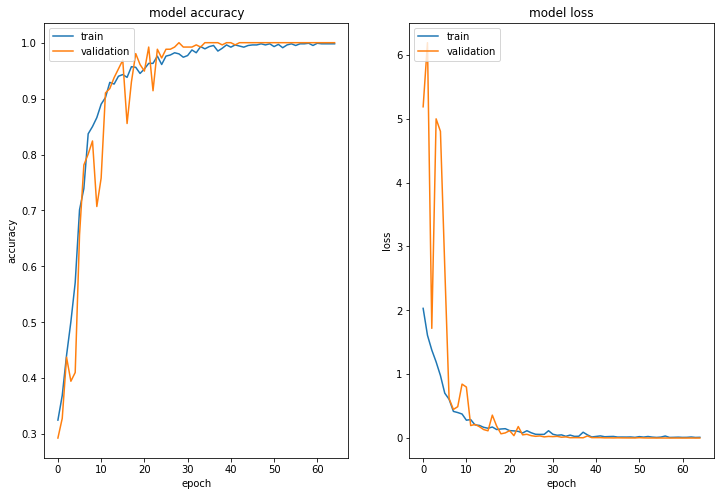

In [30]:
plot_learning_curve(history)
plt.show()

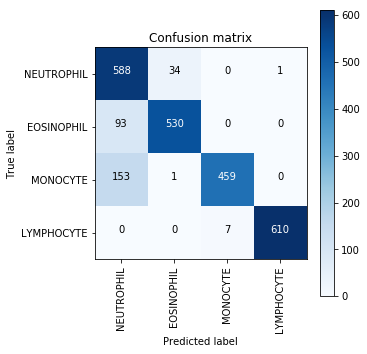

In [27]:
confusion_mtx = confusion_matrix(Y_test, Y_pred) 
plot_confusion_matrix(confusion_mtx, classes = list(dict_characters2.values())) 
plt.show()

In [28]:
accuracy_score(Y_test,Y_pred)

0.8832794830371568